## Appendix

In this notebook we predict medical cost using Gaussian process *regression*

## Importing the necessary packages



In [1]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

## Loading the insurance data
In the next cell, we will first load the dataset and then write some code to find out the shape
of our dataset.

In [2]:
#importing dataset
df = pd.DataFrame(pd.read_csv("/content/insurance.csv"))
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
#Shape of data
df.shape

(1338, 7)

In [4]:
#Describe data
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
#All columns
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

## Preprocessing
First, we want to gain some information about our data. After running this code, we can find out
the data type of each column.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
# Checking Null values
df.isnull().sum()
# There are no NULL values in the dataset, hence it is clean.

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
#Drop nan value
df = df.dropna()


After removing the null and duplicate values, we see that the number of rows has reduced by one.
In this cell we convert our string columns ‘region’, ‘sex’, and ‘smoker’ to integers.


## Bivariate & Multivariate Analysis

In the following four cells, we generate bar plots to visualize data.

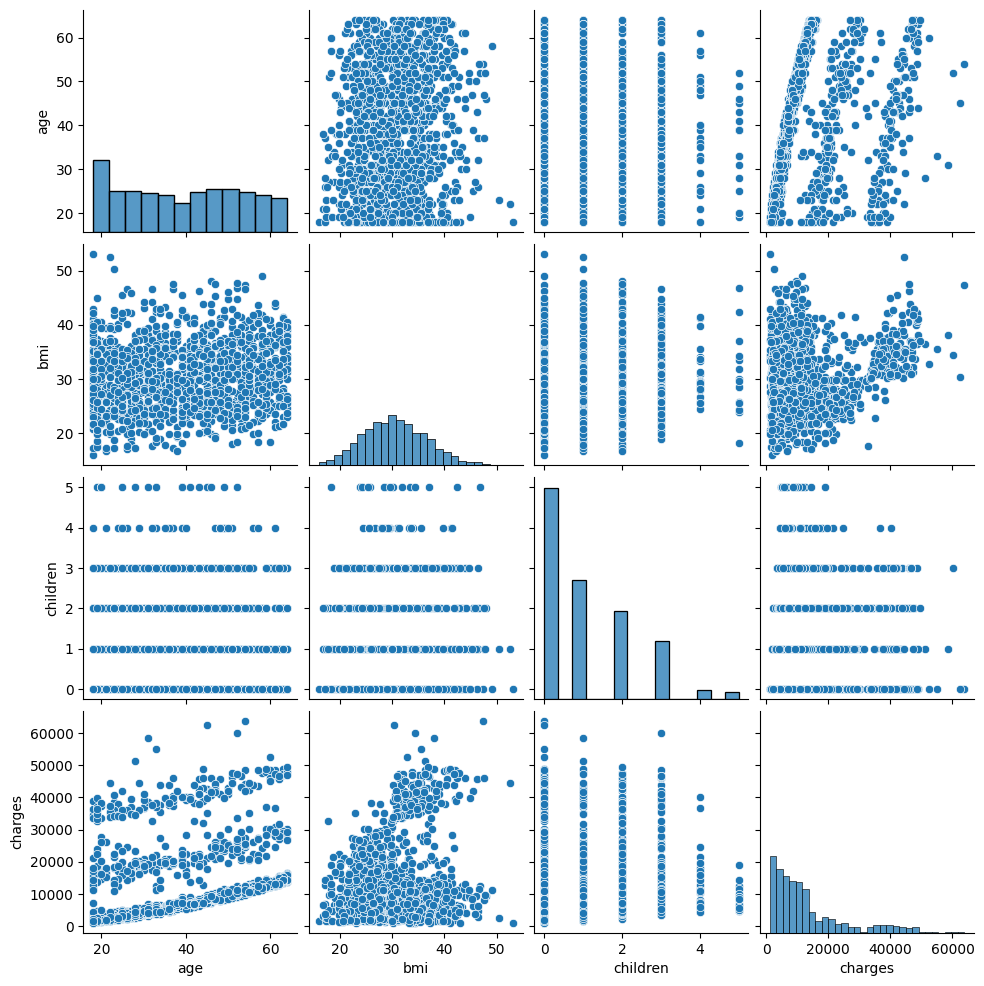

In [9]:
sns.pairplot(df)

In [10]:
#multi variate data analysis
df.groupby(['region','sex','smoker']).charges.mean()

region     sex     smoker
northeast  female  no         9640.426984
                   yes       28032.046398
           male    no         8664.042222
                   yes       30926.252583
northwest  female  no         8786.998679
                   yes       29670.824946
           male    no         8320.689321
                   yes       30713.181419
southeast  female  no         8440.205552
                   yes       33034.820716
           male    no         7609.003587
                   yes       36029.839367
southwest  female  no         8234.091260
                   yes       31687.988430
           male    no         7778.905534
                   yes       32598.862854
Name: charges, dtype: float64

In [11]:
#multi variate data analysis
df.groupby(['region','sex','smoker']).charges.sum()

region     sex     smoker
northeast  female  no        1.272536e+06
                   yes       8.129293e+05
           male    no        1.083005e+06
                   yes       1.175198e+06
northwest  female  no        1.186245e+06
                   yes       8.604539e+05
           male    no        1.098331e+06
                   yes       8.906823e+05
southeast  female  no        1.173189e+06
                   yes       1.189254e+06
           male    no        1.019606e+06
                   yes       1.981641e+06
southwest  female  no        1.161007e+06
                   yes       6.654478e+05
           male    no        9.801421e+05
                   yes       1.206158e+06
Name: charges, dtype: float64

## Dimension reduction

In [12]:
gender = pd.get_dummies(df['sex'], drop_first = True)
gender

,male
0,0
1,1
2,1
3,1
4,1
...,...
1333,1
1334,0
1335,0
1336,0


In [13]:
df = pd.concat([df, gender], axis = 1)
df

,age,sex,bmi,children,smoker,region,charges,male
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,1
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


In [14]:
region_typ = pd.get_dummies(df['region'], drop_first = False)
region_typ

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
1333,0,1,0,0
1334,1,0,0,0
1335,0,0,1,0
1336,0,0,0,1


In [15]:
df = pd.concat([df, region_typ], axis = 1)
df

,age,sex,bmi,children,smoker,region,charges,male,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,0,1,0,0
1334,18,female,31.920,0,no,northeast,2205.98080,0,1,0,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0,1,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0,0,1


In [16]:
smoker = pd.get_dummies(df['smoker'], drop_first = True)
smoker

,yes
0,1
1,0
2,0
3,0
4,0
...,...
1333,0
1334,0
1335,0
1336,0


In [17]:
df = pd.concat([df, smoker], axis = 1)


In [18]:
df

,age,sex,bmi,children,smoker,region,charges,male,northeast,northwest,southeast,southwest,yes
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0,0,1,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0,1,0,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0,1,0,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,0,1,0,0,0
1334,18,female,31.920,0,no,northeast,2205.98080,0,1,0,0,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0,1,0,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0,0,1,0


In [19]:
#drop unwanted column
df.drop(['sex','region','smoker'], axis = 1, inplace = True)

In [20]:
df

,age,bmi,children,charges,male,northeast,northwest,southeast,southwest,yes
0,19,27.900,0,16884.92400,0,0,0,0,1,1
1,18,33.770,1,1725.55230,1,0,0,1,0,0
2,28,33.000,3,4449.46200,1,0,0,1,0,0
3,33,22.705,0,21984.47061,1,0,1,0,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0,0
1334,18,31.920,0,2205.98080,0,1,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0,0
1336,21,25.800,0,2007.94500,0,0,0,0,1,0


#Correlation Matrix
In this cell we calculate the correlation matrix for the numerical columns in our DataFrame using
the “corr” function.

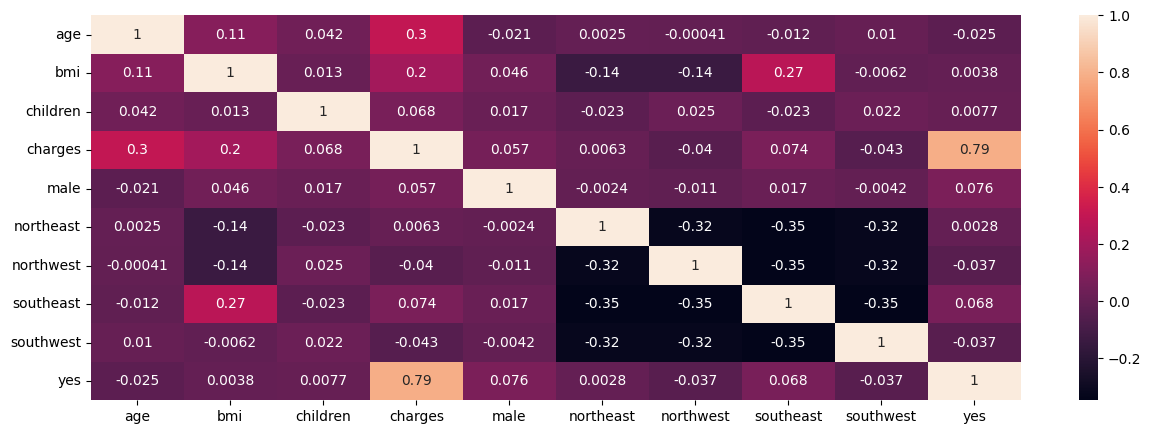

In [21]:
# Starting machine learning
import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True)
plt.show()

# Removing some of the features
Here, we remove the features that have low correlation with the target value in the hope that our
model will improve. Specifically, we remove features such as number of children, sex, and region
that have very low correlation with our target variable.


In [22]:
df = df[['age',	'bmi',	'children', 'male'	,'southwest'	,'yes','charges']]

In [23]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 1)

In [24]:
df_train

,age,bmi,children,male,southwest,yes,charges
744,50,26.410,0,1,0,0,8827.20990
363,21,26.400,1,0,1,0,2597.77900
10,25,26.220,0,1,0,0,2721.32080
970,50,28.160,3,0,0,0,10702.64240
634,51,39.700,1,1,1,0,9391.34600
...,...,...,...,...,...,...,...
715,60,28.900,0,1,1,0,12146.97100
905,26,29.355,2,0,0,0,4564.19145
1096,51,34.960,2,0,0,1,44641.19740
235,40,22.220,2,0,0,1,19444.26580


In [25]:
df_test

,age,bmi,children,male,southwest,yes,charges
559,19,35.530,0,1,0,0,1646.42970
1087,57,31.540,0,1,0,0,11353.22760
1020,51,37.000,0,1,1,0,8798.59300
460,49,36.630,3,0,0,0,10381.47870
802,21,22.300,1,1,1,0,2103.08000
...,...,...,...,...,...,...,...
323,57,40.945,0,1,0,0,11566.30055
1268,20,33.300,0,0,1,0,1880.48700
134,20,28.785,0,0,0,0,2457.21115
1274,26,27.060,0,1,0,1,17043.34140


#Splitting into train and test

In [26]:
X_train = df_train[['age',	'bmi',	'children', 'male'	,'southwest'	,'yes']]
y_train = df_train['charges']
X_test = df_train[['age',	'bmi',	'children', 'male'	,'southwest'	,'yes']]
y_test = df_train['charges']

## Gaussian process regression

In [27]:
#training the model
# kernel = DotProduct() + WhiteKernel()
#model = GaussianProcessRegressor(kernel = kernel)
model = GaussianProcessRegressor()

model.fit(X_train, y_train)

GaussianProcessRegressor()

In [28]:
# Testing
data = df_test.iloc[20:21]
actual_expenses = data.pop('charges')

print(data)
predicted_expenses = model.predict(data)
print("Actual expenses",actual_expenses)
print("predicted expenses",predicted_expenses)

# print(df_test.iloc[0:1])

     age    bmi  children  male  southwest  yes
315   52  33.25         0     1          0    0
Actual expenses 315    9722.7695
Name: charges, dtype: float64
predicted expenses [10934.45246767]


# Calculating r2 score and Mean Absolute Error

In [32]:
#test accuracy
from sklearn.metrics import r2_score
score = r2_score(y_test, model.predict(X_test))
print("The accuracy of our model is {}%".format(score *100))

The accuracy of our model is 99.99999999999766%


In [33]:
#test loss
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(y_test, model.predict(X_test))
print("The Mean Absolute Error of our Model is {}".format(score*100))

The Mean Absolute Error of our Model is 0.014233724083124667


## Plot of Training Salary vs Predicted Salary

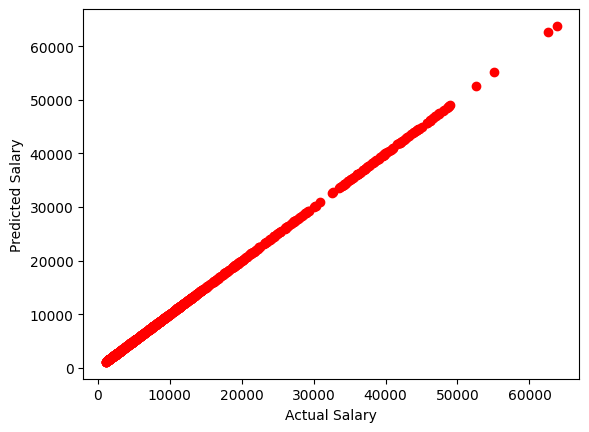

In [ ]:
#Plot of Training Actual Salary vs Predicted Salary
plt.scatter(y_train,model.predict(X_train),color = 'red')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()

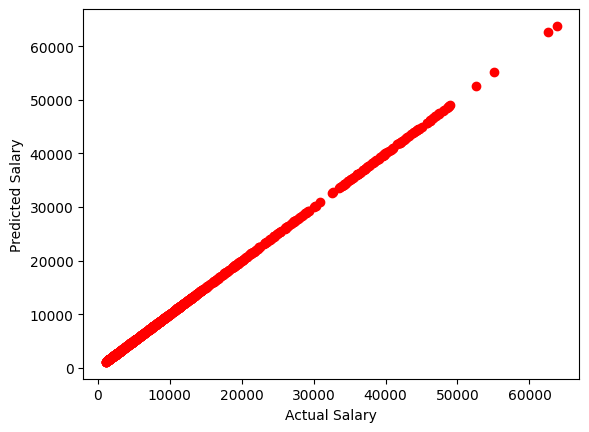

In [ ]:
#Plot of Testing Actual Salary vs Predicted Salary
plt.scatter(y_test,model.predict(X_test),color = 'red')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.show()